In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn.datasets import make_blobs
from sklearn import metrics

import matplotlib.pyplot as plt

# ### multiprocessing
# from multiprocessing.pool import Pool
# import multiprocessing


import datetime
# import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
# from math import sqrt
from pyspark.mllib.clustering import KMeans
########
from operator import *

from pyspark import SparkContext
# from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
                StructField,ArrayType, DataType
from pyspark.sql.types import *

from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
                greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum, \
                monotonically_increasing_id, pandas_udf, PandasUDFType
import pyspark.sql.functions as F

from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf
from scipy.spatial import distance
from pyspark.sql.window import Window

In [2]:
# config("spark.sql.broadcastTimeout", "300000s").\
# config("spark.network.timeout","300000s").config("spark.executor.heartbeatInterval","12000000ms").\
spark = SparkSession.builder.master("local[*]").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","24g").\
config("spark.default.parallelism", "200").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "24g").config("spark.executor.memory", "24g").\
config("spark.driver.memory", "24g")\
.appName("NPIR_Parallel").getOrCreate()


# spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
# spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
# spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [36]:
x1,y1 = make_blobs(n_samples=200, centers=3, n_features=3,
                random_state=1)
data = pd.DataFrame(x1)
data['label'] = y1
# data.head()

data = shuffle(data)
data.head()

# data.to_csv('blobs3.csv', index=False)

,0,1,2,label
151,-0.614359,5.416865,-9.926876,0
74,-1.590590,4.879731,-10.648068,0
179,-2.540037,4.684619,-10.067869,0
190,-6.076186,-3.359491,-1.783403,2
185,-3.600285,-7.135755,-8.894664,1


In [5]:
# data = shuffle(data)
# data.head()

In [6]:
# data.to_csv('blobs3.csv', index=False)

In [7]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs.csv')
# data_spark_df.show()
# data_spark_df.count()

In [8]:
data_spark_df.describe()

DataFrame[summary: string, 0: string, 1: string, 2: string, label: string]

In [9]:
data_spark_df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- label: string (nullable = true)



In [10]:
data_spark_df = data_spark_df.select(data_spark_df.columns[:-1])

In [11]:
points = data_spark_df.count()
points

5000

In [12]:
#IR: The indexing ratio to be used for generating the maximum index
# global IR, i, k
IR = 0.2
i = 10#The number of iteration i
k = 3 #k: Number of clusters
# count = Cs()
chunk = 200

In [13]:
# data_spark = data_spark_df.withColumn('index_column_name', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)
# del data_spark_df
# # data_spark.show()

In [14]:
# def unionAll(*dfs):
#     return reduce(DataFrame.unionAll, dfs)

In [15]:
# labelsheader = ('chunkLabel', 'label')
# labelsheader

In [16]:
start = timer()
# setup the spark data frame as a table

# add train/test label and expand the data set by 3x (each num trees parameter)
# data_spark_df.createOrReplaceTempView("data_spark_df")
df2 = data_spark_df.selectExpr(
    "*",
    "int(rand() * " + str(int(points / chunk)) + ") chunks",
#     "case when rand() < 0.8 then 1 else 0 end training"
)
df2 = df2.orderBy(F.col("chunks"))
# df2.show()

In [37]:
import numpy as np
data = pd.DataFrame(data.astype(float).values[:,:-1])
from NPIR import NPIR
#     label = [str(x) for x in NPIR(data.values,k,IR,i)]
#     label = (np.vstack(label).tolist())
label = NPIR(data.values,k,IR,i)
del NPIR
data['labels'] = label
leader = []
f = list(Cs(label))
f.sort()
for ii in f:
    leader.append([np.mean(z) for z in data[data['labels']==ii].values[:, :-1].T])
# del data
cols = ['P'+str(i) for i in range(k)]
leader = pd.DataFrame(leader, columns=cols)
for col in cols:
    leader[col] = leader[col].map(str)
leader['P0'][0]

'-1.5681279489142506'

In [42]:
start = timer()
structList = []
for i in range(k):
    structList.append(StructField('P' + str(i),
            ArrayType(FloatType()),
            True))
schema = StructType(structList)
# schema = StructType([StructField('label',
#             ArrayType(StringType()),
#             True)])  

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def apply_NPIR(data):
    import numpy as np
    data = pd.DataFrame(data.astype(float).values[:,:-1])
    from NPIR import NPIR
#     label = [str(x) for x in NPIR(data.values,k,IR,i)]
#     label = (np.vstack(label).tolist())
    label = NPIR(data.values,k,IR,i)
    del NPIR
    data['labels'] = label
    leader = []
    f = list(Cs(label))
    f.sort()
    for ii in f:
        leader.append([round(np.mean(z), 10) for z in data[data['labels']==ii].values[:, :-1].T])
    del data
    cols = ['P'+str(i) for i in range(k)]
    leader = pd.DataFrame(leader, columns=cols)
#     for col in cols:
#         leader[col] = leader[col].map(str)
#     return pd.DataFrame(label, columns=['label'])
    return leader


# use the Pandas UDF
# results = df2.groupby('chunks').apply(runner)
results = df2.groupby('chunks').apply(apply_NPIR)

# del data_spark
results.show()

end = timer()
print ("Execution time HH:MM:SS:", timedelta(seconds= end - start))

/opt/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 158, in create_array
    array = pa.Array.from_pandas(s, mask=mask, type=t, safe=self._safecheck)
  File "pyarrow/array.pxi", line 887, in pyarrow.lib.Array.from_pandas
  File "pyarrow/array.pxi", line 292, in pyarrow.lib.array
  File "pyarrow/array.pxi", line 83, in pyarrow.lib._ndarray_to_array
  File "pyarrow/error.pxi", line 105, in pyarrow.lib.check_status
pyarrow.lib.ArrowNotImplementedError: NumPyConverter doesn't implement <list<item: double>> conversion. 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 255, in dump_stream
    return ArrowStreamSerializer.dump_stream(self, init_stream_yield_batches(), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 88, in dump_stream
    for batch in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 249, in init_stream_yield_batches
    batch = self._create_batch(series)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 182, in _create_batch
    for field in t]
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 182, in <listcomp>
    for field in t]
  File "/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 165, in create_array
    raise RuntimeError(error_msg % (s.dtype, t), e)
RuntimeError: ('Exception thrown when converting pandas.Series (float64) to Arrow Array (list<item: double>). It can be caused by overflows or other unsafe conversions warned by Arrow. Arrow safe type check can be disabled by using SQL config `spark.sql.execution.pandas.convertToArrowArraySafely`.', ArrowNotImplementedError("NumPyConverter doesn't implement <list<item: double>> conversion. ",))


In [29]:
len(results.collect())

5000

In [23]:
# from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.types import *
# from pyspark.ml.feature import VectorAssembler
# from sklearn.ensemble import RandomForestRegressor as RFR
# from scipy.stats.stats import pearsonr

# import numpy as np
# import pandas as pd

# # load the boston data set
# from sklearn.datasets import load_boston
# boston = load_boston()

# # convert to a Pandas Data Frame
# boston_pd = pd.DataFrame(data= np.c_[boston['data'],boston['target']], 
#               columns= np.append(boston['feature_names'], 'target')).sample(frac=1)
# # convert to a Spark data frame
# boston_sp = spark.createDataFrame(boston_pd)
# display(boston_sp.take(5))

# # setup the spark data frame as a table
# boston_sp.createOrReplaceTempView("boston")

# # add train/test label and expand the data set by 3x (each num trees parameter)
# full_df = spark.sql("""
#   select *
#   from (
#     select *, case when rand() < 0.8 then 1 else 0 end as training 
#     from boston
#   ) b
#   cross join (
#       select 11 as trees union all select 20 as trees union all select 50 as trees)
# """)

# schema = StructType([StructField('trees', LongType(), True),
#                      StructField('r_squared', DoubleType(), True)])  

# @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# def train_RF(boston_pd):
#     trees = boston_pd['trees'].unique()[0]

#     # get the train and test groups 
#     boston_train = boston_pd[boston_pd['training'] == 1]
#     boston_test = boston_pd[boston_pd['training'] == 0] 
        
#     # create data and label groups 
#     y_train = boston_train['target']
#     X_train = boston_train.drop(['target'], axis=1)
#     y_test = boston_test['target']
#     X_test = boston_test.drop(['target'], axis=1)
   
#     # train a classifier 
#     rf= RFR(n_estimators = trees)
#     model = rf.fit(X_train, y_train)

#     # make predictions
#     y_pred = model.predict(X_test)
#     r = pearsonr(y_pred, y_test)
    
#     # return the number of trees, and the R value 
#     return pd.DataFrame({'trees': trees, 'r_squared': (r[0]**2)}, index=[0])
  
# # use the Pandas UDF
# results = full_df.groupby('trees').apply(train_RF)

# # print the results 
# results.show()

[Row(CRIM=3.8497, ZN=0.0, INDUS=18.1, CHAS=1.0, NOX=0.77, RM=6.395, AGE=91.0, DIS=2.5052, RAD=24.0, TAX=666.0, PTRATIO=20.2, B=391.34, LSTAT=13.27, target=21.7),
 Row(CRIM=0.02009, ZN=95.0, INDUS=2.68, CHAS=0.0, NOX=0.4161, RM=8.034, AGE=31.9, DIS=5.118, RAD=4.0, TAX=224.0, PTRATIO=14.7, B=390.55, LSTAT=2.88, target=50.0),
 Row(CRIM=10.0623, ZN=0.0, INDUS=18.1, CHAS=0.0, NOX=0.584, RM=6.833, AGE=94.3, DIS=2.0882, RAD=24.0, TAX=666.0, PTRATIO=20.2, B=81.33, LSTAT=19.69, target=14.1),
 Row(CRIM=0.07886, ZN=80.0, INDUS=4.95, CHAS=0.0, NOX=0.411, RM=7.148, AGE=27.7, DIS=5.1167, RAD=4.0, TAX=245.0, PTRATIO=19.2, B=396.9, LSTAT=3.56, target=37.3),
 Row(CRIM=0.04527, ZN=0.0, INDUS=11.93, CHAS=0.0, NOX=0.573, RM=6.12, AGE=76.7, DIS=2.2875, RAD=1.0, TAX=273.0, PTRATIO=21.0, B=396.9, LSTAT=9.08, target=20.6)]

/opt/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


+-----+------------------+
|trees|         r_squared|
+-----+------------------+
|   20|0.8962701980599501|
|   50|0.8931711325361552|
|   11|0.8765922184744865|
+-----+------------------+



In [15]:
leaderheadr = ['chunkLabel', 'old label']
# leaderheadr = []
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
# leaderheadr

In [ ]:
# spark_cluster_centroid = sqlContext.createDataFrame(([c.tolist() for c in clusters.centers]),)
# spark_cluster_centroid = spark_cluster_centroid.withColumn('defined_cluster', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)

In [17]:
start = timer()
# labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
# labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    
    del NPIR
    data['labels'] = label

#     # Adding to pyspard label
#     chunklabel = np.full(len(label), ii).tolist()
#     labelDF = [(x, y) for x, y in zip(chunklabel, label)]
#     labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
#     labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:, :-1].T])
    del data
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1
del data_spark
end = timer()
print ("Execution time HH:MM:SS:", timedelta(seconds= end - start))

KeyboardInterrupt: 

In [ ]:
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs3.csv')

In [81]:
# def Euclidean_distance(a,b,c,d):
#     a = float(a)
#     b = float(b)
#     c = float(c)
#     d = float(d)
#     array1 = np.array([a,b])
#     array2 = np.array([c,d])
#     dist = np.linalg.norm(array1-array2)
#     dist = dist.item()
#     return dist

# Euclidean_distance_spark = udf(lambda x,y,z,t: Euclidean_distance(x,y,z,t), FloatType())
# sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

In [ ]:
start = timer()
# parsedData = leaders.select(['1', '2']).rdd.map(list)
leaders.toPandas().to_csv('leaders.csv')
del leaders
leaders_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('leaders.csv')
parsedData = leaders_spark_df.select(leaders_spark_df.columns[2:]).rdd.map(list)
del leaders_spark_df

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
start = timer()
# leaders_spark_df = leaders_spark_df.select('1', '2')
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
del parsedData
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
dataCol = data_spark_df.columns

In [ ]:
start = timer()
############ Updateing points clusters
for i in range(k):
    if i == 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_spark_df.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        del data_spark_df
        data_cent = data_cent.withColumn('mindist', col('dis' + str(i) + 'th'))
        data_cent
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
    elif i > 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_cent.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))#4
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
data_cent = data_cent.drop('mindist')

# data_cent.show()

In [ ]:
def Min_COl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(Min_COl, IntegerType())

data_cent = data_cent.withColumn('defined_cluster', find_min_val_name(*data_cent.\
            columns[len(dataCol):len(dataCol) + 1 + k]))
# data_cent.show()

In [ ]:
# for c in range(k):
#     data_cent = data_cent.drop('dis' + str(c) + 'th')
# # data_cent.show()

In [ ]:
d = data_cent.select('defined_cluster').toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
data = pd.read_csv('blobs3.csv')
data.head()

In [92]:
# data = data[['0','1','label']]

In [93]:
# data['new'] = d['defined_cluster'].astype('int8')
# data.head()

,0,1,label,new
0,-0.847703,3.443641,0,0
1,-0.879711,6.074268,0,0
2,-7.130045,-6.249592,2,0
3,-9.181510,-5.423167,1,0
4,-1.821064,2.555991,0,0


In [ ]:
y = data['label']
labelsPred = d['defined_cluster'].astype('int8')
# x = data[['0','1']].values
# x.shape

In [ ]:
del data
del d

In [ ]:
#printing results
#print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

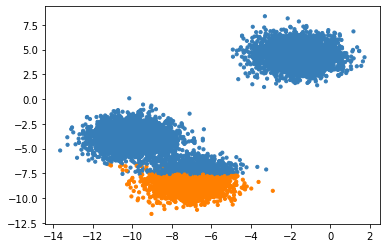

In [97]:
# import matplotlib.pyplot as plt
# from itertools import cycle, islice 

# fig = plt.figure()      
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
#                                     '#999999', '#e41a1c', '#dede00']),int(k))))
# plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
# plt.show()
# # plt.clf()